In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style
import matplotlib

import gensim as gensim
import nltk
from sklearn.feature_extraction.text import CountVectorizer
import re

import json

In [2]:
reddit_df = pd.read_csv(r'C:\UNT\Courses\INFO 6945\Reddit\reddit.csv', encoding = 'unicode_escape')

print(reddit_df.shape)
reddit_df

(9721, 11)


,post_id,title,selftext,url,author,score,publish_date,num_of_comments,permalink,flair,key_word
0,7nlpzs,Playing with a more delicate representation of...,NaN,https://i.redd.it/x7cn304ovm701.jpg,paddyb7981,1,1/2/2018 4:43,0,/r/food/comments/7nlpzs/playing_with_a_more_de...,Vegan/Vegetarian,Vegan
1,7npmbn,"Vegan Ramen, took me 2 hours to make the broth...",NaN,https://i.redd.it/rt4o2ry94q701.jpg,tomaz90,1,1/2/2018 15:37,0,/r/food/comments/7npmbn/vegan_ramen_took_me_2_...,NaN,Vegan
2,7nr0x1,[I ate] vegan blue Sheppard's Pie,NaN,https://i.redd.it/yerch8ge5r701.jpg,peeppeeppeeper,1,1/2/2018 19:05,0,/r/food/comments/7nr0x1/i_ate_vegan_blue_shepp...,NaN,Vegan
3,7nu86p,[Homemade] Recipe Tofu Meat Loaf and Vegan TVP,NaN,https://www.youtube.com/attribution_link?a=bOF...,jasmin6391,1,1/3/2018 6:04,1,/r/food/comments/7nu86p/homemade_recipe_tofu_m...,NaN,Vegan
4,7nz0cd,Vegan Chocolate Coconut Caramel Cupcake [Homem...,NaN,https://i.redd.it/08l29ylc1y701.jpg,angielusbakery,1,1/3/2018 18:15,0,/r/food/comments/7nz0cd/vegan_chocolate_coconu...,NaN,Vegan
...,...,...,...,...,...,...,...,...,...,...,...
9716,u7f9a7,[I ate] Elk meat pasty,NaN,https://i.imgur.com/OlYb5aE.jpg,lo-key-glass,1,4/19/2022 15:54,1,/r/food/comments/u7f9a7/i_ate_elk_meat_pasty/,NaN,meat
9717,u8hi3q,[homemade] veal meat ð (last Saturday),NaN,https://www.reddit.com/gallery/u8hi3q,THE_VOLK87,1,4/21/2022 1:57,1,/r/food/comments/u8hi3q/homemade_veal_meat_las...,NaN,meat
9718,u8hisw,veal meat [homemade] last Saturday,NaN,https://www.reddit.com/gallery/u8hisw,THE_VOLK87,1,4/21/2022 1:58,1,/r/food/comments/u8hisw/veal_meat_homemade_las...,NaN,meat
9719,u90yob,[Homemade]This is my take on a Japanese Gyudon...,NaN,https://i.redd.it/dgmaw5l3zyu81.jpg,Irizarryeats,1,4/21/2022 18:49,1,/r/food/comments/u90yob/homemadethis_is_my_tak...,NaN,meat


In [3]:
# Get all posts(string) in a list

posts_list = reddit_df['title'].tolist()
        
print("Total number of posts: \n{} \n".format(len(posts_list)))
print("Sample posts: \n{}".format(posts_list[:3]))

Total number of posts: 
9721 

Sample posts: 
['Playing with a more delicate representation of the English Classic â\x80\x98Eton Messâ\x80\x99 also Vegan Friendly', 'Vegan Ramen, took me 2 hours to make the broth and it was worth it.', "[I ate] vegan blue Sheppard's Pie"]


In [4]:
from nltk.tokenize import RegexpTokenizer
# splits string into substrings using a regular expression
# tokenises words that contain 1 or more (+) alphanumeric characters (\w) or '@'
retokenizer = RegexpTokenizer(r'[\w@]+')

# create stop words list
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
# add context specific stop words
stop_words += ["rt", "got", "thats", "would", "going", "u", "get", 
                "also", "one", "could", "said", "like", "singapore",
                "coronavirus", "covid", "say"]

# create lemmatizer
wnl = nltk.stem.wordnet.WordNetLemmatizer()

# text pre-processing functions 
def remove_urls(s):
    # re.sub(pattern,repl,string) is used to replace substrings. Will replace the matches in string with repl
    return re.sub(r'https?://\S+', "", s)

def remove_usernames(s):
    return re.sub(r'@\S+', "", s)

def remove_specialchar(text, remove_digits=False):    
    if not remove_digits:
        pattern = r'[^a-zA-z0-9\s]'
    else:
        pattern = r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

In [5]:
def process_text(documents):
    processed_docs = []
    doc_tokens = []
    for doc in documents:
        doc = doc.lower()
        doc = remove_urls(doc)
        doc = remove_usernames(doc)
        doc = remove_specialchar(doc, remove_digits=True)
        doc_tokens = retokenizer.tokenize(doc)
        doc_tokens = [token for token in doc_tokens if token not in stop_words]
        doc_tokens = [wnl.lemmatize(token) for token in doc_tokens]    
#         doc = ' '.join(doc_tokens)
        processed_docs.append(doc_tokens)
#         print(doc_tokens)
    return processed_docs

In [6]:
processed_posts = process_text(posts_list)
print(len(processed_posts))
# print(processed_posts)

9721


# Topic Modelling

In [7]:
# Create a dictionary representation of the documents. Each word gets an id
dictionary = gensim.corpora.Dictionary(processed_posts)

print('Sample word to id mappings:\n', list(dictionary.items())[:75])
print('Total Vocabulary Size:', len(dictionary))

Sample word to id mappings:
 [(0, 'classic'), (1, 'delicate'), (2, 'english'), (3, 'eton'), (4, 'friendly'), (5, 'mess'), (6, 'playing'), (7, 'representation'), (8, 'vegan'), (9, 'broth'), (10, 'hour'), (11, 'make'), (12, 'ramen'), (13, 'took'), (14, 'worth'), (15, 'ate'), (16, 'blue'), (17, 'pie'), (18, 'sheppards'), (19, 'homemade'), (20, 'loaf'), (21, 'meat'), (22, 'recipe'), (23, 'tofu'), (24, 'tvp'), (25, 'caramel'), (26, 'chocolate'), (27, 'coconut'), (28, 'cupcake'), (29, 'bbq'), (30, 'burger'), (31, 'falafel'), (32, 'level'), (33, 'next'), (34, 'southampton'), (35, 'uk'), (36, 'union'), (37, 'hemp'), (38, 'best'), (39, 'cuisine'), (40, 'enjoy'), (41, 'food'), (42, 'indian'), (43, 'mississauga'), (44, 'place'), (45, 'first'), (46, 'fresh'), (47, 'lasagna'), (48, 'themicrowave'), (49, 'l'), (50, 'meating'), (51, 'melody'), (52, 'misc'), (53, 'pleasure'), (54, 'pragmatic'), (55, 'schoenfeld'), (56, 'chilli'), (57, 'dog'), (58, 'green'), (59, 'mini'), (60, 'mustard'), (61, 'new'), 

# Create the vector space model (bag of words model in gensim)

In [8]:
# Transforming corpus into bag of words vectors
corpus_vect = [dictionary.doc2bow(text) for text in processed_posts]

In [10]:
# Check how the vector looks for the second document

print(corpus_vect[2])
print("\n", )
print(processed_posts[2])

[(8, 1), (15, 1), (16, 1), (17, 1), (18, 1)]


['ate', 'vegan', 'blue', 'sheppards', 'pie']


In [11]:
print(type(corpus_vect))
print(len(corpus_vect))

<class 'list'>
9721


In [17]:
# Viewing them as terms and their document frequencies, index into the dictionary

print([(dictionary[id] , freq) for id, freq in corpus_vect[1][:20]])

[('vegan', 1), ('broth', 1), ('hour', 1), ('make', 1), ('ramen', 1), ('took', 1), ('worth', 1)]


# Build the LDA model

In [13]:
num_topics = 4

In [15]:
pip install pickle

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle


In [32]:
# Build LDA model

ldamodel = gensim.models.ldamodel.LdaModel(corpus_vect, num_topics = num_topics, id2word=dictionary, passes=25)

In [33]:
print(type(ldamodel))

<class 'gensim.models.ldamodel.LdaModel'>


In [34]:
print(ldamodel.print_topics(num_topics = num_topics, num_words = 10))

[(0, '0.184*"meat" + 0.087*"homemade" + 0.051*"cheese" + 0.039*"ate" + 0.016*"board" + 0.013*"smoked" + 0.013*"pizza" + 0.012*"pie" + 0.012*"sauce" + 0.010*"platter"'), (1, '0.070*"meat" + 0.038*"homemade" + 0.034*"vegetable" + 0.033*"ate" + 0.018*"noodle" + 0.018*"rice" + 0.012*"pork" + 0.011*"dish" + 0.009*"roll" + 0.009*"fish"'), (2, '0.068*"vegan" + 0.017*"homemade" + 0.016*"recipe" + 0.014*"made" + 0.013*"food" + 0.010*"cake" + 0.010*"chocolate" + 0.008*"make" + 0.008*"first" + 0.008*"best"'), (3, '0.098*"homemade" + 0.067*"vegetable" + 0.024*"chicken" + 0.023*"sauce" + 0.020*"potato" + 0.019*"vegan" + 0.016*"roasted" + 0.013*"rice" + 0.012*"grilled" + 0.011*"garlic"')]


In [35]:
# Show top 10 words for each topic
# Topic will be inferred from the words

for num ,topic in ldamodel.show_topics(formatted=True, num_topics=num_topics, num_words=10):
    print(str(num)+": "+ topic)

0: 0.184*"meat" + 0.087*"homemade" + 0.051*"cheese" + 0.039*"ate" + 0.016*"board" + 0.013*"smoked" + 0.013*"pizza" + 0.012*"pie" + 0.012*"sauce" + 0.010*"platter"
1: 0.070*"meat" + 0.038*"homemade" + 0.034*"vegetable" + 0.033*"ate" + 0.018*"noodle" + 0.018*"rice" + 0.012*"pork" + 0.011*"dish" + 0.009*"roll" + 0.009*"fish"
2: 0.068*"vegan" + 0.017*"homemade" + 0.016*"recipe" + 0.014*"made" + 0.013*"food" + 0.010*"cake" + 0.010*"chocolate" + 0.008*"make" + 0.008*"first" + 0.008*"best"
3: 0.098*"homemade" + 0.067*"vegetable" + 0.024*"chicken" + 0.023*"sauce" + 0.020*"potato" + 0.019*"vegan" + 0.016*"roasted" + 0.013*"rice" + 0.012*"grilled" + 0.011*"garlic"


In [45]:
# To access and print topics from LDA model

topics = ldamodel.show_topics(formatted=True, num_topics=num_topics, num_words=10)
print(topics[3])

(3, '0.098*"homemade" + 0.067*"vegetable" + 0.024*"chicken" + 0.023*"sauce" + 0.020*"potato" + 0.019*"vegan" + 0.016*"roasted" + 0.013*"rice" + 0.012*"grilled" + 0.011*"garlic"')


# Compute Coherence Score

In [46]:
from gensim.models import CoherenceModel

# Compute Coherence Score for LDA Model
coherence_model_lda = CoherenceModel(model=ldamodel, texts=processed_posts, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.38130755693010204


# Get Dominoin Topic for each post

In [47]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=ldamodel, corpus=corpus_vect, texts=processed_posts)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2.0,0.9241,"vegan, homemade, recipe, made, food, cake, cho...","[playing, delicate, representation, english, c..."
1,1,2.0,0.5309,"vegan, homemade, recipe, made, food, cake, cho...","[vegan, ramen, took, hour, make, broth, worth]"
2,2,3.0,0.5878,"homemade, vegetable, chicken, sauce, potato, v...","[ate, vegan, blue, sheppards, pie]"
3,3,0.0,0.5232,"meat, homemade, cheese, ate, board, smoked, pi...","[homemade, recipe, tofu, meat, loaf, vegan, tvp]"
4,4,2.0,0.8859,"vegan, homemade, recipe, made, food, cake, cho...","[vegan, chocolate, coconut, caramel, cupcake, ..."
5,5,2.0,0.4917,"vegan, homemade, recipe, made, food, cake, cho...","[next, level, vegan, falafel, burger, union, b..."
6,6,3.0,0.4168,"homemade, vegetable, chicken, sauce, potato, v...","[ate, next, level, vegan, falafel, burger]"
7,7,3.0,0.4508,"homemade, vegetable, chicken, sauce, potato, v...","[ate, vegan, hemp, burger]"
8,8,2.0,0.9247,"vegan, homemade, recipe, made, food, cake, cho...","[enjoy, best, indian, cuisine, mississauga, ve..."
9,9,2.0,0.5237,"vegan, homemade, recipe, made, food, cake, cho...","[homemade, first, vegan, lasagna, fresh, themi..."


In [65]:
df_dominant_topic.sort_values(by=['Dominant_Topic']).head(4000)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,Dominant_Topic_Label
9720,9720,0.0,0.8482,"meat, homemade, cheese, ate, board, smoked, pi...","[homemade, minced, meat, pie]",Meat
7096,7096,0.0,0.6741,"meat, homemade, cheese, ate, board, smoked, pi...","[homemade, wife, made, small, wonderful, meat,...",Meat
7095,7095,0.0,0.6402,"meat, homemade, cheese, ate, board, smoked, pi...","[wife, made, small, beautiful, meat, cheese, b...",Meat
7094,7094,0.0,0.8669,"meat, homemade, cheese, ate, board, smoked, pi...","[homemade, meat, cheese, board, friend]",Meat
7091,7091,0.0,0.6370,"meat, homemade, cheese, ate, board, smoked, pi...","[homemade, tomato, meat, tortilla, chip, cheese]",Meat
...,...,...,...,...,...,...
6659,6659,1.0,0.7156,"meat, homemade, vegetable, ate, noodle, rice, ...","[homemade, pork, belly, burnt, end, aka, meat,...",Mixed food
3410,3410,1.0,0.6041,"meat, homemade, vegetable, ate, noodle, rice, ...","[homemade, noodle, twicefried, chicken, vegeta...",Mixed food
8773,8773,1.0,0.9357,"meat, homemade, vegetable, ate, noodle, rice, ...","[homemade, japchae, mixed, dish, boiled, bean,...",Mixed food
6638,6638,1.0,0.5788,"meat, homemade, vegetable, ate, noodle, rice, ...","[meat, substitute, market, booming, worldwide,...",Mixed food


In [66]:
# Add the topic labels

topic_label = {0.0: 'Meat',
              1.0: 'Mixed Foods',
              2.0: 'Vegeterian',
              3.0: 'Homemade foods'}

df_dominant_topic['Dominant_Topic_Label'] = df_dominant_topic['Dominant_Topic'].apply(lambda x: topic_label[x])
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,Dominant_Topic_Label
0,0,2.0,0.9241,"vegan, homemade, recipe, made, food, cake, cho...","[playing, delicate, representation, english, c...",Vegeterian
1,1,2.0,0.5309,"vegan, homemade, recipe, made, food, cake, cho...","[vegan, ramen, took, hour, make, broth, worth]",Vegeterian
2,2,3.0,0.5878,"homemade, vegetable, chicken, sauce, potato, v...","[ate, vegan, blue, sheppards, pie]",Homemade foods
3,3,0.0,0.5232,"meat, homemade, cheese, ate, board, smoked, pi...","[homemade, recipe, tofu, meat, loaf, vegan, tvp]",Meat
4,4,2.0,0.8859,"vegan, homemade, recipe, made, food, cake, cho...","[vegan, chocolate, coconut, caramel, cupcake, ...",Vegeterian
5,5,2.0,0.4917,"vegan, homemade, recipe, made, food, cake, cho...","[next, level, vegan, falafel, burger, union, b...",Vegeterian
6,6,3.0,0.4168,"homemade, vegetable, chicken, sauce, potato, v...","[ate, next, level, vegan, falafel, burger]",Homemade foods
7,7,3.0,0.4508,"homemade, vegetable, chicken, sauce, potato, v...","[ate, vegan, hemp, burger]",Homemade foods
8,8,2.0,0.9247,"vegan, homemade, recipe, made, food, cake, cho...","[enjoy, best, indian, cuisine, mississauga, ve...",Vegeterian
9,9,2.0,0.5237,"vegan, homemade, recipe, made, food, cake, cho...","[homemade, first, vegan, lasagna, fresh, themi...",Vegeterian


[Text(0.5, 0, 'Topics'), Text(0, 0.5, 'Number of Reddit Posts')]

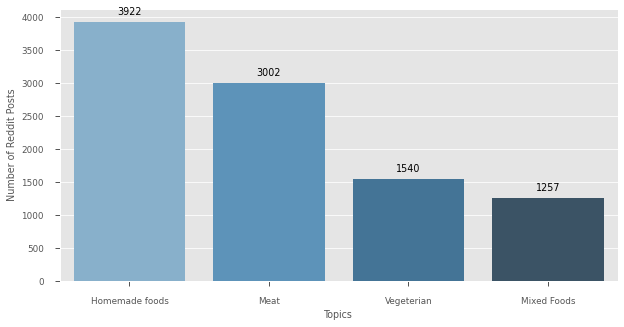

In [67]:
# Visualise contribution of each topics to Reddit Posts 

#### Plot settings ####
style.use('seaborn-poster') #sets the size of the charts
style.use('ggplot')
matplotlib.rcParams['font.family'] = "DejaVu Sans"
plt.rcParams['figure.figsize'] = [10, 5]
sns.set_context('paper')
####


# Plot chart
ax = sns.countplot(x="Dominant_Topic_Label",
                    data=df_dominant_topic,
                    order = df_dominant_topic['Dominant_Topic_Label'].value_counts().index,
                    palette=("Blues_d"))


# Add value labels
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

    
# Change width of bars
# def change_width(ax, new_value) :
#     for patch in ax.patches :
#         current_width = patch.get_width()
#         diff = current_width - new_value

#         # we change the bar width
#         patch.set_width(new_value)

#         # we recenter the bar
#         patch.set_x(patch.get_x() + diff * .5)
# change_width(ax, .60)


# Add axis labels
ax.set(xlabel='Topics', ylabel='Number of Reddit Posts')


# plt.savefig('reddit_topic_contribution.png', dpi=400, transparent=True, bbox_inches="tight")

# Get the Most Representative Sentence Of Each Topic

In [68]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf = pd.concat([sent_topics_sorteddf, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9641,"meat, homemade, cheese, ate, board, smoked, pizza, pie, sauce, platter","[turkey, meat, product, market, size, share, key, growth, driver, analysis, challenge, leading, ..."
1,1.0,0.9549,"meat, homemade, vegetable, ate, noodle, rice, pork, dish, roll, fish","[homemade, tonkotsu, ramen, homemade, pork, broth, chashu, pork, belly, ajitsuke, tamago, simmer..."
2,2.0,0.9748,"vegan, homemade, recipe, made, food, cake, chocolate, make, first, best","[vegan, chocolate, frosting, review, minute, vegan, gluten, free, make, cup, easy, vegan, chocol..."
3,3.0,0.9686,"homemade, vegetable, chicken, sauce, potato, vegan, roasted, rice, grilled, garlic","[homemade, grilled, rosemary, chicken, roasted, vegetable, tapenade, bell, pepper, zucchini, egg..."


In [70]:
# Retrieve the representative posts for topic 0 -- Local Cases

topic0_reptext = sent_topics_sorteddf['Representative Text'][0]
topic0_index = processed_posts.index(topic0_reptext)

topic0_reppost = reddit_df.iloc[topic0_index]
topic0_reppost

post_id                                                                                                         b2hhw7
title              Turkey Meat Products Market Size, Share, Key Growth Drivers, Analysis, Challenges, Leading Key P...
selftext                                                                                                           NaN
url                https://www.nbc29.com/story/40132267/turkey-meat-products-market-size-share-key-growth-drivers-a...
author                                                                                                  chitradeo00777
score                                                                                                                1
publish_date                                                                                            3/18/2019 6:20
num_of_comments                                                                                                      0
permalink                                   /r/f

In [73]:
# Retrieve the representative tweet for topic 3 -- Policy Measures

topic3_reptext = sent_topics_sorteddf['Representative Text'][3]
topic3_index = processed_posts.index(topic3_reptext)

topic3_reppost = reddit_df.iloc[topic3_index]
topic3_reppost

post_id                                                                                                         pi4u0f
title              [Homemade] Grilled Rosemary Chicken on Roasted Vegetables Tapenade (Bell Peppers, Zucchini, Eggp...
selftext                                                                                                           NaN
url                                                                                https://i.redd.it/3f2kls2ujll71.jpg
author                                                                                                   4food_is_love
score                                                                                                                1
publish_date                                                                                            9/4/2021 21:35
num_of_comments                                                                                                      0
permalink                                       

# Visualise topics

In [76]:
import pyLDAvis.gensim_models

In [78]:
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(ldamodel, corpus_vect, dictionary)

C:\Users\jesud\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


In [79]:
# Show visualisation
p

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.115631 -0.215336       1        1  38.015261
0     -0.099787  0.230797       2        1  26.580387
2      0.306575 -0.008243       3        1  19.311898
1     -0.091157 -0.007218       4        1  16.092453, topic_info=          Term         Freq        Total Category  logprob  loglift
21        meat  4720.000000  4720.000000  Default  30.0000  30.0000
347  vegetable  2406.000000  2406.000000  Default  29.0000  29.0000
164     cheese  1060.000000  1060.000000  Default  28.0000  28.0000
8        vegan  1684.000000  1684.000000  Default  27.0000  27.0000
15         ate  1554.000000  1554.000000  Default  26.0000  26.0000
..         ...          ...          ...      ...      ...      ...
356      fried    65.976449   378.190645   Topic4  -5.2500   0.0807
41        food    59.026473   261.364868   Topic4  -5.3613   0.3389
546      mixed    51.281297   181.669316   Topic4  -5.5020   0.5620
81       spicy    51.230307   200.145346   Topic4  -5.5030   0.4641
130        amp    50.315475   461.277666   Topic4  -5.5210  -0.3889

[219 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
130       1  0.509455      amp
130       2  0.381549      amp
130       4  0.108395      amp
15        1  0.180082      ate
15        2  0.515165      ate
...     ...       ...      ...
3624      4  0.976232    wagyu
885       4  0.984111     wild
2583      2  0.966481  wrapped
1320      2  0.045771     year
1320      3  0.945931     year

[241 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 3, 2])

In [80]:
# Save visualisation to html page
pyLDAvis.save_html(p, 'reddit_lda.html')

# Finalize Model

In [81]:
#save model to disk
pickle.dump(ldamodel, open("reddit_topics", "wb"))

In [82]:
#load model from disk
ldamodel = pickle.load(open("reddit_topics", 'rb'))
for num ,topic in ldamodel.show_topics(formatted=True, num_topics=num_topics, num_words=10):
    print(str(num)+": "+ topic)

0: 0.184*"meat" + 0.087*"homemade" + 0.051*"cheese" + 0.039*"ate" + 0.016*"board" + 0.013*"smoked" + 0.013*"pizza" + 0.012*"pie" + 0.012*"sauce" + 0.010*"platter"
1: 0.070*"meat" + 0.038*"homemade" + 0.034*"vegetable" + 0.033*"ate" + 0.018*"noodle" + 0.018*"rice" + 0.012*"pork" + 0.011*"dish" + 0.009*"roll" + 0.009*"fish"
2: 0.068*"vegan" + 0.017*"homemade" + 0.016*"recipe" + 0.014*"made" + 0.013*"food" + 0.010*"cake" + 0.010*"chocolate" + 0.008*"make" + 0.008*"first" + 0.008*"best"
3: 0.098*"homemade" + 0.067*"vegetable" + 0.024*"chicken" + 0.023*"sauce" + 0.020*"potato" + 0.019*"vegan" + 0.016*"roasted" + 0.013*"rice" + 0.012*"grilled" + 0.011*"garlic"


# Save & Restore Notebook Session

In [83]:
!pip install dill

  Using cached dill-0.3.4-py2.py3-none-any.whl (86 kB)


In [84]:
import dill

In [85]:
#save notebook session
dill.dump_session('reddit_lda.db')

In [86]:
#restore notebook session
dill.load_session('reddit_lda.db')